#Natural Language Processing Of News Headlines


##Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

tfds.disable_progress_bar()

## Training And Testing Data Processing and Split For Model Training


###Convert Positive Negative and Neutral to 2, 0 and 1 respectively

In [ ]:
def databinary(filenamein, filenameout):
    data=pd.read_csv(filenamein)
    dn=(data['label'])
    data['label'].replace('Positive', 2, inplace=True)
    data['label'].replace('Neutral', 1, inplace=True)
    data['label'].replace('Negative', 0, inplace=True)
    data.to_csv(filenameout, index=False)

databinary('stock_news.csv', 'outnew.csv')


data=pd.read_csv('Sentences_66Agree.txt', sep='@', encoding='latin-1')
data.columns = ['headline', 'label']

dn=(data['label'])
data['label'].replace('positive', 2, inplace=True)
data['label'].replace('neutral', 1, inplace=True)
data['label'].replace('negative', 0, inplace=True)

data.to_csv('sentences_new2.csv', index=False)

##Read Data

<ipython-input-31-3e1295138e8b>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(tok) for tok in train_data['headline']])


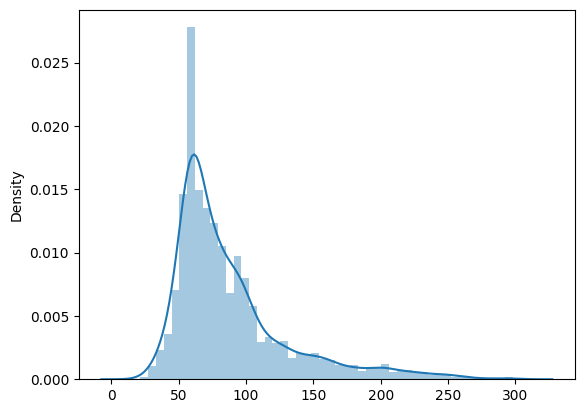

In [ ]:
data2=pd.read_csv('Sentences_66Agree.txt', sep='@', encoding='latin-1')
data2.columns = ['headline', 'label']

data = pd.read_csv('outnew.csv')
data2=pd.read_csv('sentences_new2.csv')
data.pop('Unnamed: 0')

data2=data2.sort_values(by='label')
data2.replace(2, 1, inplace=True)
data2neg=data2.iloc[1:499]
data2pos=data2.iloc[(4012-1168):]

datanegative = data.iloc[0:514]
dataneutral = data.iloc[4804:(4804 + 4804)]
datapositive = data.iloc[(4804 + 8748):(4804 + 8478 + 5074)]
data = pd.concat([datanegative, datapositive, data2pos, data2neg], ignore_index=True)

data['label'].replace(2, 1, inplace=True)

# Shuffle the data
data = data.sample(frac=1)

# Split into train and test sets
train_data = data[0:int(len(data) * 0.75)]
test_data = data[int(len(data) * 0.75):]

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['headline'], train_data['label']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data['headline'], test_data['label']))

sns.distplot([len(tok) for tok in train_data['headline']])
plt.savefig('headlinelength_dist2.svg')

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
data

,headline,label
3077,MGM Resorts (MGM) Stock Gains on Q1 Earnings &...,1
1009,"Textron Aviation Delivers 8,000th Cessna Citat...",1
1430,ICE Clear Credit Announces the Expansion of It...,1
5865,Both operating profit and net sales for the si...,1
6858,"Scanfil , a systems supplier and contract manu...",0
...,...,...
1122,Fundamentals Reveal that Cash Flow is Understa...,1
5990,That would be an increase from estimated sales...,1
3893,10 Dividend Stocks to Buy Now According to Ker...,1
5047,Howmet Aerospace Clocks 13% Revenue Growth In ...,1


##Model Compiling And Fitting

In [ ]:
# This code was adapted from TensorFlow/Resources/Text/Tutorials
# https://www.tensorflow.org/text/tutorials/text_classification_rnn
# a useful guide fornatural language processing using a BiLSTM.



VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=80)
encoder.adapt(train_dataset.map(lambda x, y: x))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(4e-3
                                                 ),
              metrics=['Precision', 'Accuracy', 'Recall']
              )

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=10)

Epoch 1/10
85/85 [==============================] - 37s 270ms/step - loss: 0.3453 - precision: 0.8844 - Accuracy: 0.8685 - recall: 0.9735 - val_loss: 0.2707 - val_precision: 0.9179 - val_Accuracy: 0.9000 - val_recall: 0.9711
Epoch 2/10
85/85 [==============================] - 7s 77ms/step - loss: 0.1060 - precision: 0.9709 - Accuracy: 0.9596 - recall: 0.9822 - val_loss: 0.3479 - val_precision: 0.9160 - val_Accuracy: 0.9094 - val_recall: 0.9855
Epoch 3/10
85/85 [==============================] - 6s 71ms/step - loss: 0.0302 - precision: 0.9926 - Accuracy: 0.9889 - recall: 0.9944 - val_loss: 0.4985 - val_precision: 0.9228 - val_Accuracy: 0.9062 - val_recall: 0.9729
Epoch 4/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0179 - precision: 0.9959 - Accuracy: 0.9935 - recall: 0.9965 - val_loss: 0.5382 - val_precision: 0.9256 - val_Accuracy: 0.9047 - val_recall: 0.9675
Epoch 5/10
85/85 [==============================] - 3s 38ms/step - loss: 0.0155 - precision: 0.9974 - Accu

In [ ]:
fig=plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('(a)')

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('(b)')


plt.tight_layout
plt.savefig('improvedmodelstats.svg')
plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 80)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 80, 64)            640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 1

##

##New Dataset Generation Using Model

###Dataset Pre-Processing

In [ ]:
def predict(string):
  sample_text = np.array((string))
  x = model.predict(np.array([sample_text]))
  return (x)

In [ ]:
headlinedata = pd.read_csv('analyst_ratings_processed.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'analyst_ratings_processed.csv'

In [ ]:

apple=headlinedata.loc[headlinedata['stock'] == 'AAPL']
nvidia=headlinedata.loc[headlinedata['stock'] == 'NVDA']
google=headlinedata.loc[headlinedata['stock'] == 'GOOGL']
amazon=headlinedata.loc[headlinedata['stock'] == 'AMZN']
berk=headlinedata.loc[headlinedata['stock'] == 'BRK']

allstocks=pd.concat([nvidia, apple, google, amazon, berk], ignore_index=True)

allstocks=allstocks.sort_values(by='date')
allstocks=(allstocks[876:])

NameError: name 'headlinedata' is not defined

In [ ]:
allstocks['title']=allstocks['title'].apply(predict)

allstocks.to_csv('allstockssentiment.csv')

NameError: name 'allstocks' is not defined

In [ ]:
allstocks

,Unnamed: 0,title,date,stock
2579,931632.0,[[0.999969]],2013-12-18 16:38:00-05:00,NVDA
2578,931631.0,[[0.9999583]],2014-01-09 08:55:00-05:00,NVDA
2577,931630.0,[[0.99997604]],2014-01-09 14:05:00-05:00,NVDA
2576,931629.0,[[0.0035170172]],2014-01-09 14:20:00-05:00,NVDA
6051,186841.0,[[0.9925506]],2014-01-10 16:25:00-05:00,BRK
...,...,...,...,...
3133,7120.0,[[0.99999464]],2020-06-10 11:33:00-04:00,AAPL
1,929040.0,[[0.9997515]],2020-06-10 12:12:00-04:00,NVDA
0,929039.0,[[0.9999976]],2020-06-10 12:37:00-04:00,NVDA
5187,76869.0,[[0.9999901]],2020-06-10 13:18:00-04:00,AMZN


In [ ]:
dateSentiment = {} #for preprocessing

dateSentiment[allstocks['date'].iloc[0].split()[0]] = allstocks['title'].iloc[0][0][0] #start with the first row

companies = {allstocks['stock'].iloc[0]: allstocks['title'].iloc[0][0][0]} #companies that have headlines on that day with their most recent sentiment

i = 1 #iterator
counter = 1 #counter of how many headlines that day
while i < len(allstocks): #iterate through entire dataset
    yesterday = allstocks['date'].iloc[i-1].split()[0] #yesterday's date
    date = allstocks['date'].iloc[i].split()[0] #current date
    prevSentiment = allstocks['title'].iloc[i-1][0][0]
    sentiment = allstocks['title'].iloc[i][0][0] #sentiment of current date
    stock = allstocks['stock'].iloc[i] #current row's stock name

    if (date not in dateSentiment): #date not being in the dictionary implies new day
        dateSentiment[yesterday] = dateSentiment[yesterday] / counter #first average out the previous day's sentiment

        dateSentiment[date] = sentiment #add new day's sentiment value currently
        companies = {stock: sentiment} #reset company headlines for that day to the current date with first company
        counter = 1 #reset amount of headlines that day to 1

    elif (stock not in companies): #if the stock is not the same name, increase sentiment value by the amount that stock's sentiment value has
        dateSentiment[date] += sentiment
        companies[stock] = sentiment
        counter += 1    #increase amount of headlines for that day by 1

    elif (abs(sentiment - companies[stock]) > 0.3 or abs(sentiment - companies[stock]) < 0.3):    #if the stock is the same name and the sentiment value is past the 0.3 threshold difference, then add sentiment
        dateSentiment[date] += sentiment
        companies[stock] = sentiment #overwrite old sentiment to new sentiment
        counter += 1 #increase amount of headlines again

    i += 1

NameError: name 'allstocks' is not defined

###Dataframe Creation

In [ ]:

dffinal=pd.DataFrame.from_dict(dateSentiment,orient='index', columns=['Sentiment'])
dffinal.index.name='Date'

NameError: name 'dateSentiment' is not defined

In [ ]:
dffinal=dffinal.reset_index()

In [ ]:
dffinal

,index,Date,Sentiment
0,0,2013-12-18,0.999969
1,1,2014-01-09,0.667817
2,2,2014-01-10,0.992551
3,3,2014-01-13,0.999996
4,4,2014-01-14,1.000000
...,...,...,...
1174,1174,2020-06-06,0.999999
1175,1175,2020-06-07,0.999986
1176,1176,2020-06-08,0.999897
1177,1177,2020-06-09,0.999973


In [ ]:
def formatconverter(year):
  seperation = year.split("-") #[2017, 11, 17]
  newstr = seperation[1] + "/" + seperation[2] + "/" + seperation[0]
  return newstr


In [ ]:
dffinal.loc[:,'Date']= dffinal.Date.apply(formatconverter)

NameError: name 'dffinal' is not defined

In [ ]:
sp500data=pd.read_csv('SP500.csv')




In [ ]:
sp500data.drop(['Open', 'High', 'Low'], axis=1, inplace=True)


In [ ]:
sp500data

,Date,Close/Last
0,01/19/2024,4839.81
1,01/18/2024,4780.94
2,01/17/2024,4739.21
3,01/16/2024,4765.98
4,01/12/2024,4783.83
...,...,...
2527,01/28/2014,1792.50
2528,01/27/2014,1781.56
2529,01/24/2014,1790.29
2530,01/23/2014,1828.46


In [ ]:
dffinal['Date'] = pd.to_datetime(dffinal['Date'], format='%m/%d/%Y')
sp500data['Date'] = pd.to_datetime(sp500data['Date'], format='%m/%d/%Y')

data = pd.merge(sp500data, dffinal, on='Date', how='left').ffill()


NameError: name 'dffinal' is not defined

In [ ]:
data=(data[908:])

In [ ]:
data.to_csv('SP500_sentiment2.csv')

In [ ]:
result=(result[7:1177])